# Model Evaluation Protocol
The Evaluation Protocol Will Evaluate the best hyperparameter configuration for each Learning Algorithm used in the model Selection.

Therefore, following Steps will be performed:
1. Train a model for each learning algorithm using the optimal hyperparameter configuration
-- Train the model on the whole cross validation dataset
2. Test each models performance using ROC AUC Score (Mean OvR ROC AUC)
-- The test will be performed using the test dataset
3. Analyze the OvR ROC Curves for each model to determine whether one model is clearly better than the others
4. Determine the best performing model(s)/algorithm(s)


In [89]:
import pandas as pd
from pandas import DataFrame


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, roc_curve

# Load Data

In [90]:
path_cross_val_data: str = r"D:\Documents\GitHub\UNI_Stellar_Classification\Data\cross_validation_data.csv"
path_test_data: str = r"D:\Documents\GitHub\UNI_Stellar_Classification\Data\test_data.csv"

cross_validation_data: DataFrame = pd.read_csv(path_cross_val_data, index_col="index")
x_cross_val: DataFrame = cross_validation_data.drop("target", axis=1)
y_cross_val: DataFrame = cross_validation_data.target

test_data: DataFrame = pd.read_csv(path_test_data, index_col="index")
x_test: DataFrame = test_data.drop("target", axis=1)
y_test: DataFrame = test_data.target

# Final Hyperparameter Combination for each of the trained Models

| Model Name | Max Fraction Selected Features | Number of Estimators | Mean ROC AUC Score (OvR method) |
|------------|:------------------------------:|:--------------------:|:-------------------------------:|
| Bagging    |              1.0               |         200          |             0.9944              |

<br>
<br>

| Model Name    | Max Depth | Min Sample Split | Number of Estimators | Mean ROC AUC Score (OvR method) |
|---------------|:---------:|:----------------:|:--------------------:|:-------------------------------:|
| Random Forest |    20     |        5         |         200          |             0.9955              |

<br>
<br>

| Model Name    | Max Depth | Min Sample Leaf | Criterion | Mean ROC AUC Score (OvR method) |
|---------------|:---------:|:---------------:|:---------:|:-------------------------------:|
| Decision Tree |    10     |       10        |  entropy  |             0.9901              |

<br>
<br>

| Model Name          | Num Iterations | Mean ROC AUC Score (OvR method) |
|---------------------|:--------------:|:-------------------------------:|
| Logistic Regression |     10000      |             0.9832              |

# Train a model for each algorithm using best hyperparameter

In [91]:
model_configurations: dict = {
    "bagging": {
        "model": BaggingClassifier,
        "model_label": "Bagging Classifier",
        "hyperparameter": {
            "n_estimators": 200,
            "max_features": 1.0,
        }
    },
    "random_forest": {
        "model": RandomForestClassifier,
        "model_label": "Random Forrest Classifier",
        "hyperparameter": {
            "n_estimators": 200,
            "min_samples_split": 5,
            "max_depth": 20,
            "class_weight": "balanced"
        }
    },
    "decision_tree": {
        "model": DecisionTreeClassifier,
        "model_label": "Decision Tree Classifier",
        "hyperparameter": {
            "max_depth": 10,
            "min_samples_leaf": 10,
            "criterion": "entropy",
            "class_weight": "balanced"
        }
    },
    "log_reg": {
        "model": LogisticRegression,
        "model_label": "Logistic Regression Classifier",
        "hyperparameter": {
            "max_iter": 10000,
        }
    },
}

# for roc auc ovr we need one hot encoded targets
label_binarizer = LabelBinarizer().fit(y_cross_val)
y_onehot_test = label_binarizer.transform(y_test)

for model_name in model_configurations.keys():
    model_config: dict = model_configurations[model_name]

    # initialize and fit estimator
    estimator = model_config["model"](**model_config["hyperparameter"])
    estimator.fit(x_cross_val, y_cross_val)
    model_config["estimator"] = estimator

    # save predictions on test data as one-hot encodings
    model_config["test_one_hot_predictions"] = label_binarizer.transform(estimator.predict(x_test))

    # predict_proba returns the fraction of each class in the terminal node: [p(Galaxy), p(Quasar), p(Star)] is returned
    model_config["test_predictions_probabilities"] = estimator.predict_proba(x_test)

D:\Documents\GitHub\UNI-Dynamic_Programming_and_Reinforcement_Learning\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Compute Weighted Roc Auc Score for each model

In [92]:
for model_name in model_configurations.keys():
    model_config: dict = model_configurations[model_name]
    model_config["roc_auc_score"] = roc_auc_score(y_true=y_test, y_score=model_config["test_predictions_probabilities"], multi_class="ovr")
    print(f"Weighted ROC AUC score on test data {model_config['model_label']:<50}: {model_config['roc_auc_score']}")

Weighted ROC AUC score on test data Bagging Classifier                                : 0.9955182558020664
Weighted ROC AUC score on test data Random Forrest Classifier                         : 0.9963716536873544
Weighted ROC AUC score on test data Decision Tree Classifier                          : 0.9923128724527887
Weighted ROC AUC score on test data Logistic Regression Classifier                    : 0.9841758315806525


# Plot One versus Rest Receiver Operation Curve

The ROC curve is a measure for the performance of binary classification problems. Since in this project deals with multiclass classification, the ROC curve cannot be computed w.r.t to all three classes the same time.

As mentioned before, the One versus Rest method considers one class as the positive class and all other classes together as the negative class. This reduces the multiclass classification into a binary classification situation. However, instead of one ROC curve, the One versus Rest method produces N ROC curves, where N is the number of unique classes. Every class will be treated once as the dominant class and N-1 times as part of the aggregated negative class.

e.g. In this project there exist three distinct classes namely:
GALAXY, QSA, STAR.

The OvR method will produce the following ROC curves
<br>

| Positive Class | Negative Class |
|:--------------:|:--------------:|
|     GALAXY     |   QSA + STAR   |
|      QSA       | GALAXY + STAR  |
|      STAR      |  QSA + GALAXY  |

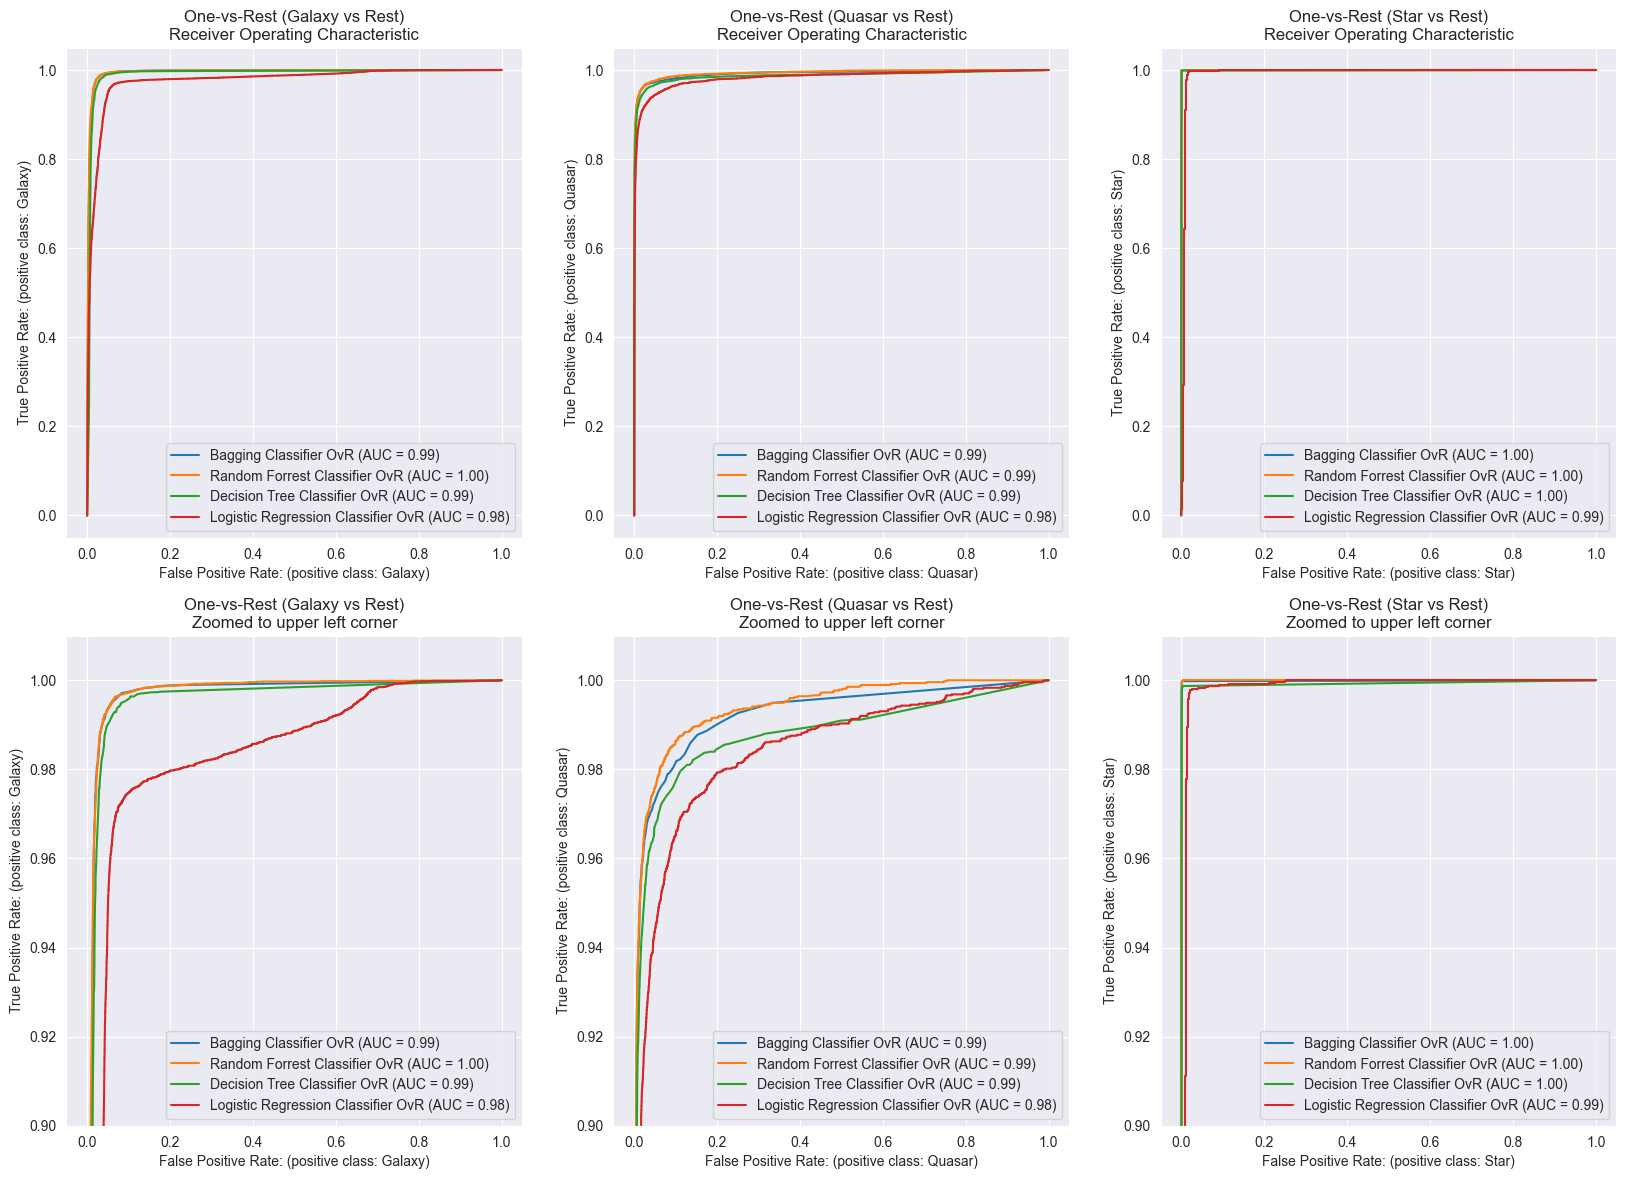

In [117]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# compare ovr roc curves for each model
"""
the mapping from labels to numbers is as follows
GALAXY  = 0 = [1, 0, 0]
QSO     = 1 = [0, 1, 0]
STAR    = 2 = [0, 0, 1]
"""

fig, ax = plt.subplots(2, 3, figsize=(20, 14))

# for galaxy
for i, class_name in enumerate(["Galaxy", "Quasar", "Star"]):
    for model_name in model_configurations.keys():
        predictions = model_configurations[model_name]["test_predictions_probabilities"][:, i]
        y_true = y_onehot_test[:, i]
        RocCurveDisplay.from_predictions(
            y_true,
            predictions,
            name=f"{model_configurations[model_name]['model_label']} OvR",
            ax=ax[0][i],

        )

    ax[0][i].set_title(f"One-vs-Rest ({class_name} vs Rest)\nReceiver Operating Characteristic")
    ax[0][i].set_xlabel(f"False Positive Rate: (positive class: {class_name})")
    ax[0][i].set_ylabel(f"True Positive Rate: (positive class: {class_name})")

    for model_name in model_configurations.keys():
        predictions = model_configurations[model_name]["test_predictions_probabilities"][:, i]
        y_true = y_onehot_test[:, i]
        RocCurveDisplay.from_predictions(
            y_true,
            predictions,
            name=f"{model_configurations[model_name]['model_label']} OvR",
            ax=ax[1][i],

        )

    ax[1][i].set_title(f"One-vs-Rest ({class_name} vs Rest)\nZoomed to upper left corner")
    ax[1][i].set_xlabel(f"False Positive Rate: (positive class: {class_name})")
    ax[1][i].set_ylabel(f"True Positive Rate: (positive class: {class_name})")
    ax[1][i].set_ylim((0.9, 1.01))